In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [11]:
import re

In [13]:
sentences = """Throughout my career, I have had the opportunity to work on a diverse range of mobile app projects. My proficiency in Flutter, along with my Android development skills, has allowed me to create user-friendly and high-performance applications. I take pride in my ability to transform creative concepts into functional, feature-rich apps that deliver exceptional user experiences."""

In [15]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [17]:
words = sentences.split()
vocab = set(words)

In [19]:
vocab

{'ability',
 'allowed',
 'along',
 'and',
 'android',
 'app',
 'applications',
 'apps',
 'career',
 'concepts',
 'create',
 'creative',
 'deliver',
 'development',
 'diverse',
 'exceptional',
 'experiences',
 'feature',
 'flutter',
 'friendly',
 'functional',
 'had',
 'has',
 'have',
 'high',
 'in',
 'into',
 'me',
 'mobile',
 'my',
 'of',
 'on',
 'opportunity',
 'performance',
 'pride',
 'proficiency',
 'projects',
 'range',
 'rich',
 'skills',
 'take',
 'that',
 'the',
 'throughout',
 'to',
 'transform',
 'user',
 'with',
 'work'}

In [21]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

In [23]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [25]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['throughout', 'my', 'have', 'had'], 'career'), (['my', 'career', 'had', 'the'], 'have'), (['career', 'have', 'the', 'opportunity'], 'had'), (['have', 'had', 'opportunity', 'to'], 'the'), (['had', 'the', 'to', 'work'], 'opportunity')]


In [27]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

In [29]:
def linear(m, theta):
    w = theta
    return m.dot(w)

In [31]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [33]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [35]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- out + softmax) / logits.shape[0]

In [37]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)

    return m, n, o

In [39]:
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)

    return dw

In [41]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [43]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [45]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)


    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

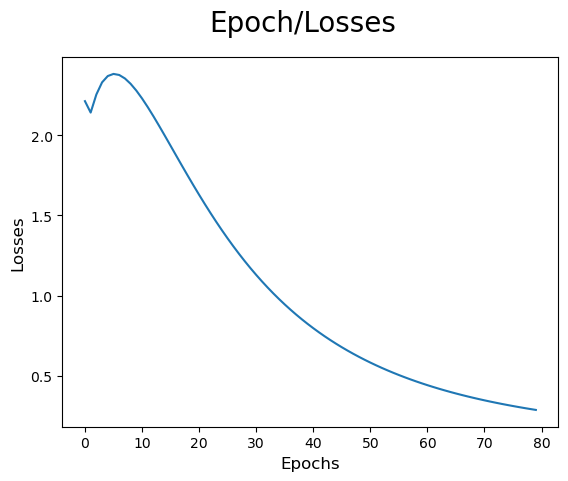

In [47]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [49]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]

    return word

In [51]:

predict(['transform','creative','into','functional' ])

'concepts'

In [53]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1

    return (1 - (wrong / len(data)))

In [55]:
accuracy()

1.0